In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import random


In [11]:

# Load and clean data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/demand.csv")
data.dropna(inplace=True)

In [12]:
# Features and target
X = data[['Store ID', 'Total Price', 'Base Price']].values
y = data['Units Sold'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# -------- Build a Decision Tree Regressor from scratch -------- #
class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=5, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _build_tree(self, X, y, depth):
        if len(y) < self.min_samples_split or depth >= self.max_depth:
            return np.mean(y)

        best_feat, best_val, best_score, best_split = None, None, float('inf'), None

        for feat in range(X.shape[1]):
            values = np.unique(X[:, feat])
            for val in values:
                left = y[X[:, feat] <= val]
                right = y[X[:, feat] > val]
                if len(left) > 0 and len(right) > 0:
                    score = np.var(left) * len(left) + np.var(right) * len(right)
                    if score < best_score:
                        best_feat = feat
                        best_val = val
                        best_score = score
                        best_split = (X[:, feat] <= val)

        if best_feat is None:
            return np.mean(y)

        left_tree = self._build_tree(X[best_split], y[best_split], depth + 1)
        right_tree = self._build_tree(X[~best_split], y[~best_split], depth + 1)

        return (best_feat, best_val, left_tree, right_tree)

    def predict(self, X):
        return np.array([self._predict_input(x, self.tree) for x in X])

    def _predict_input(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feat, val, left, right = tree
        return self._predict_input(x, left) if x[feat] <= val else self._predict_input(x, right)

# -------- Random Forest Regressor from scratch -------- #
class RandomForestRegressorScratch:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=10, sample_size=0.8):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.sample_size = sample_size
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            idxs = np.random.choice(n_samples, int(self.sample_size * n_samples), replace=True)
            tree = DecisionTreeRegressorScratch(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)

# Train and evaluate
model = RandomForestRegressorScratch(n_estimators=10, max_depth=10, min_samples_split=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

print('R2:', r2_score(y_test, y_pred))
print('MAE:', np.mean(np.abs(y_test - y_pred)))
print('MSE:', np.mean((y_test - y_pred) ** 2))
print('RMSE:', np.sqrt(np.mean((y_test - y_pred) ** 2)))

R2: 0.47662223062706255
MAE: 24.102125291232962
MSE: 1622.2290130761005
RMSE: 40.276904214153554


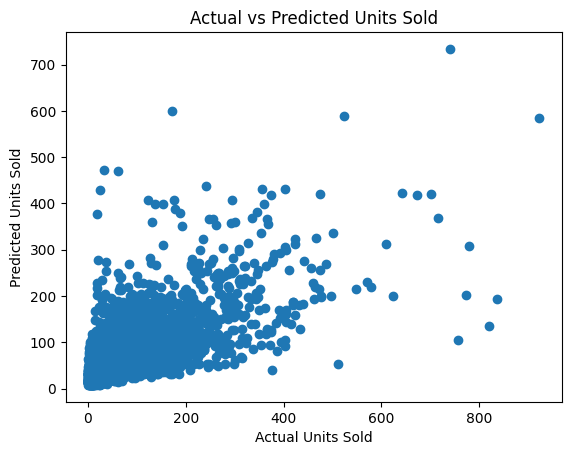

In [13]:
# Plot
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.show()